# Ames Housing

Predict the value of SalePrice variable

## 1. Import Data

In [1057]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

warnings.filterwarnings("ignore")

In [957]:
import os

def get_dataset(data_dir, train_fn, test_fn):

    train_path = os.path.join(data_dir, train_fn)
    test_path = os.path.join(data_dir, test_fn)

    return pd.read_csv(train_path), pd.read_csv(test_path)

train_set, test_set = get_dataset('dataset', 'train.csv', 'test.csv')

In [958]:
train_set.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [959]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [960]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

Store Id column and drop them from training and test set (not necessary for predictions)

In [961]:
train_ID = train_set['Id']
test_ID = test_set['Id']

X_train = train_set.drop('Id', axis=1)
X_test = test_set.drop('Id', axis=1)

## 2. Analyzing Data

Render **histogram of dependent variable** `SalePrice`

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

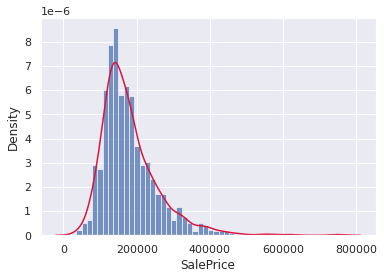

In [962]:
sns.histplot(X_train['SalePrice'], stat='density', kde=False, bins=50)
sns.kdeplot(X_train['SalePrice'], cut=3, color='crimson')

- Deviate from normal distribution
- Positive skewed
- Show peakedness (high *kurtosis*)

In [963]:
print(f'Skewness: {X_train.SalePrice.skew():.2f}')
print(f'Kurtosis: {X_train.SalePrice.kurt():.2f}')

Skewness: 1.88
Kurtosis: 6.54


Let's see how variables are correlated using a **Correlation Matrix (heatmap)**.

<AxesSubplot:>

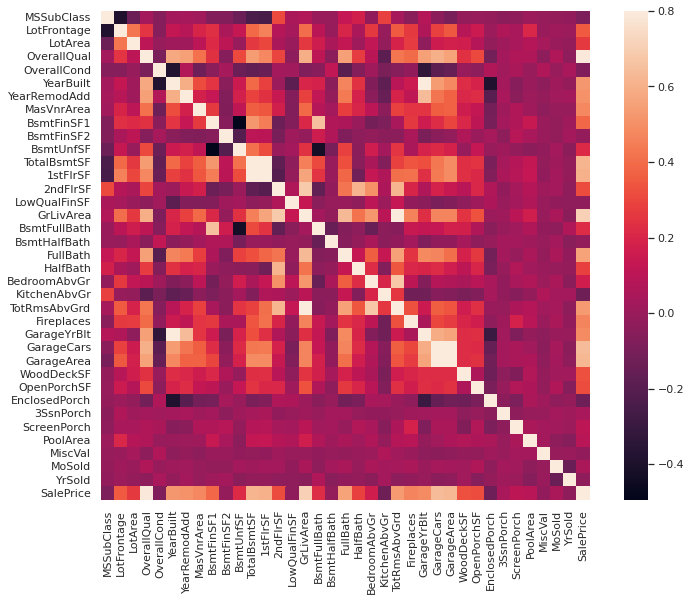

In [964]:
corrmat = X_train.corr()
f, ax = plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=.8, square=True)

Notice bright white squares. These are strong linear correlations between nearing variables. The correlation is so strong that it could indicate that multicollinearity. The biggest perpetrators are `TotalBsmtSF` with `1stFlrSF`, `GarageCars` with `GarageArea`, `GrLivArea` with `TotRmsAbvGrd`, and `YearBuilt` with `GarageYrBlt`.

Also note that the strong correlations between certain variables are our dependent variable, SalePrice. This includes `OverallQual`, `GrLivArea`, `GarageCars`, `GarageArea`, `TotalBsmtSF`, `1stFlrSF`, and to some extent `YearBuilt`, `FullBath`, and a few others.

**Zoomed correlation matrix**

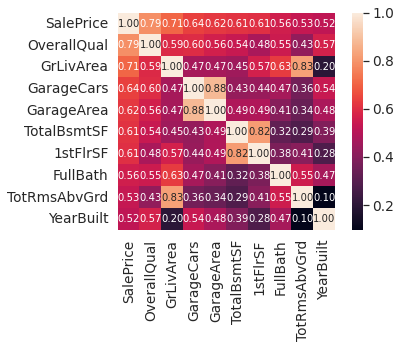

In [965]:
k = 10 # number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(X_train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

Here we can see which variables have the strongest linear correlation to `SalePrice`. From the previous heatmap we know that both pairs `(GarageCars, GarageArea)` and `(TotalBsmtSF, 1stFlrSF)` are strongly related. Therefore, we can ignore one from each pair to avoid multicollinearity. Let's keep `GarageCars` and `TotalBsmtSF` since they have a slightly stronger correlation to `SalePrice`.

We can also see that `GrLivArea` and `TotRmsAbvGrd` have a strong correlation, suggesting mulitcollinearity. Perhaps we can drop `TotalRmsAbvGrd` as well. 

**Scatter plots between `SalePrice` and correlated variables**

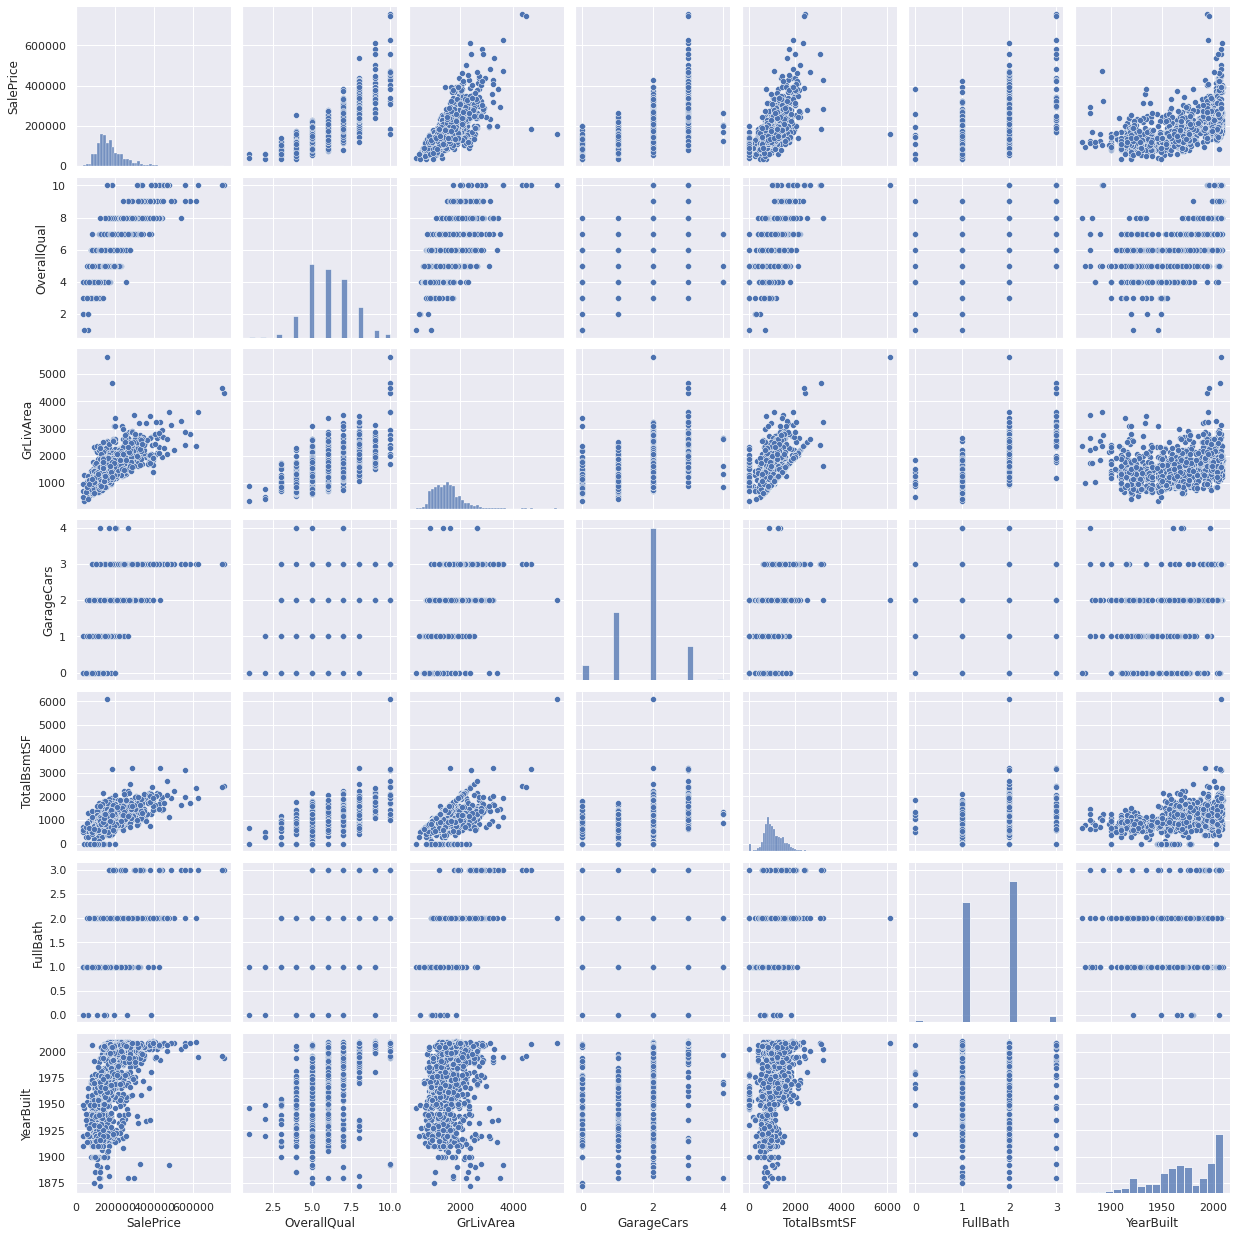

In [966]:
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(X_train[cols], size=2.5)
plt.show()

## 3. Data Processing

#### **Outliers**

Documentation suggests there may be outliers present in the training data

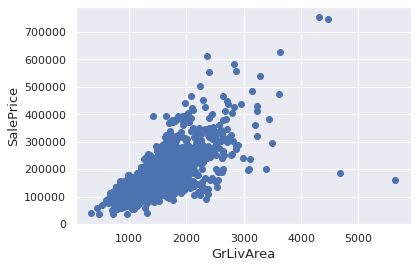

In [967]:
fig, ax = plt.subplots()
ax.scatter(x = X_train['GrLivArea'], y = X_train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

Remove two values in the bottom right

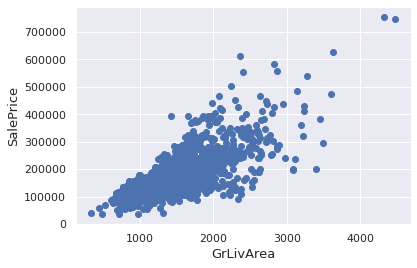

In [968]:
#Deleting outliers 
X_train = X_train.drop(X_train[(X_train['GrLivArea']>4000) & (X_train['SalePrice']<300000)].index)

#Check the graphic again
fig, ax = plt.subplots()
ax.scatter(X_train['GrLivArea'], X_train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

Careful deleting too many outliers because they may show up in the test set. We want the models to be robust enough to handle them.

`SalePrice` is the dependent variable (what we need to predict) so let's do some analysis on it


 mu = 180932.92 and sigma = 79467.79



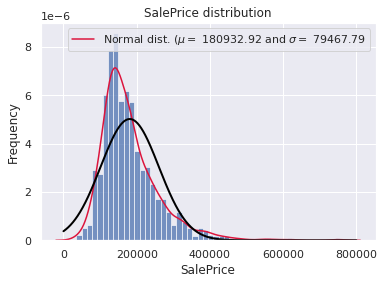

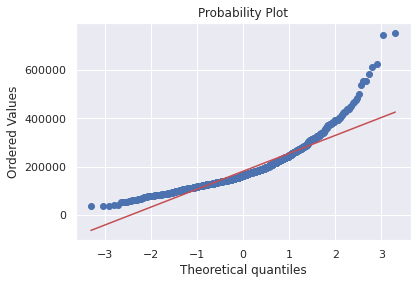

In [969]:
def normal(mean, std, color="black"):
    x = np.linspace(0, 800000, 1000)
    p = stats.norm.pdf(x, mean, std)
    z = plt.plot(x, p, color, linewidth=2)

sns.histplot(X_train['SalePrice'], stat='density', kde=False, bins=50)
sns.kdeplot(X_train['SalePrice'], cut=3, color='crimson')

# get fitted parameters used by the function
(mu, sigma) = stats.norm.fit(X_train['SalePrice'])
print(f'\n mu = {mu:.2f} and sigma = {sigma:.2f}\n')

normal(mu, sigma)

# now plot the distribution
plt.legend([f'Normal dist. ($\mu=$ {mu:.2f} and $\sigma=$ {sigma:.2f}'], loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

# also get the QQ-plot
fig = plt.figure()
res = stats.probplot(X_train['SalePrice'], plot=plt)
plt.show()

Target variable is right skewed. Linear models love normally distributed data, so we need to transform this variable to make it more normally distributed.

#### **Log-Transformation of the target variable**


 mu = 12.02 and sigma = 0.40



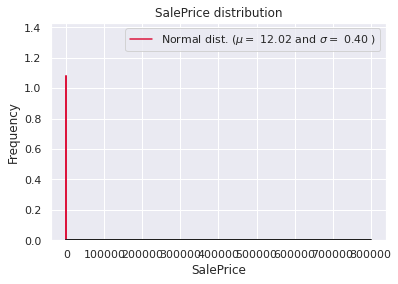

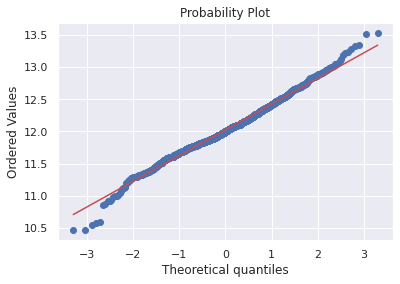

In [970]:
# use np.log1p which applies log(1+x) to all elements of the column
X_train['SalePrice'] = np.log1p(X_train['SalePrice'])

sns.histplot(X_train['SalePrice'], stat='density', kde=False, bins=50)
sns.kdeplot(X_train['SalePrice'], cut=3, color='crimson')

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(X_train['SalePrice'])
print(f'\n mu = {mu:.2f} and sigma = {sigma:.2f}\n')

normal(mu, sigma)

#Now plot the distribution
plt.legend([f'Normal dist. ($\mu=$ {mu:.2f} and $\sigma=$ {sigma:.2f} )'],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(X_train['SalePrice'], plot=plt)
plt.show()

Much better

### **Features engineering**

Drop unecessary and problem (multicollinearity) features from training and test set

In [971]:
y_train = X_train['SalePrice']
X_train = X_train.drop(['SalePrice', '1stFlrSF', 'GarageArea', 'TotRmsAbvGrd', 'GarageYrBlt'], axis=1)
X_test = X_test.drop(['1stFlrSF', 'GarageArea', 'TotRmsAbvGrd', 'GarageYrBlt'], axis=1)

In [972]:
X_train.shape, X_test.shape

((1458, 75), (1459, 75))

#### **Missing Data**

Important questions when thinking about missing data:
- How prevalent is the missing data?
- Is missing data random or does it have a pattern?

In [973]:
all_data = pd.concat([X_train, X_test]).reset_index(drop=True)
total = all_data.isnull().sum().sort_values(ascending=False)
percent = (all_data.isnull().sum()/all_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(34)

,Total,Percent
PoolQC,2908,0.996915
MiscFeature,2812,0.964004
Alley,2719,0.932122
Fence,2346,0.804251
FireplaceQu,1420,0.486802
LotFrontage,486,0.166610
GarageCond,159,0.054508
GarageFinish,159,0.054508
GarageQual,159,0.054508
GarageType,157,0.053822


There are elements missing from both training and test sets. We'll have to fill them in if possible. Note that we don't want to introduce bias to the test set by filling them in with any value. If the documentation states that a missing value represents something (like None or 0) then we will fill both sets with those values. Otherwise, we'll have to find the most common or median value within the training set and fill the test set with those values. If values are missing from a feature in the test set but no in the training set, we are left with no other option besides filling it in with whatever we can.

Descriptions for the following variables states that NA means:
- `PoolQC`: no pool
- `MiscFeatures`: no misc features
- `Alley`: no alley
- `Fence`: no fence
- `FireplaceQu`: no fireplace
- `GarageType`, `GarageFinish`, `GarageQual`, `GarageCond`: no garage
- `BsmtQual`, `BsmtCond`, `BsmtExposure`, `BsmtFinType1`, `BsmtFinType2`: no basement
- `MasVnrType`: no masonry veneer

In [974]:
for col in ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 
    'GarageCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType',
    'MSSubClass']:
    X_train[col] = X_train[col].fillna('None')
    X_test[col] = X_test[col].fillna('None')

- `GarageYrBlt`, `GarageArea`, `GarageCars`: replace missing data with 0 (since No garage means no cars in such garage)
- `BsmtFinSF1`, `BsmtFinSF2`, `BsmtUnSF`, `TotalBsmtSF`, `BsmtFullBath`, `BsmtHalfBath`: missing values are likely zero for having no basement
- `MasVnrArea`: likely 0 for no masonry veneer

In [975]:
for col in ['GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 
    'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea']:
    X_train[col] = X_train[col].fillna(0)
    X_test[col] = X_test[col].fillna(0)

Fill missing values with most frequent category for:
- `MSZoning`
- `Electrical`
- `KitchenQual`
- `Exterior1st`
- `Exterior2nd`
- `SaleType`

In [976]:
for col in ['Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType', 'MSZoning']:
    X_train[col] = X_train[col].fillna(X_train[col].mode()[0])
    X_test[col] = X_test[col].fillna(X_test[col].mode()[0])

`Utilities`: This feature won't help in predictive modeling so we can safely remove it (all recording features are the same category). 

In [977]:
X_train = X_train.drop('Utilities', axis=1)
X_test = X_test.drop('Utilities', axis=1)

`Function` feature with value NaN refers to "Typical"

In [978]:
X_train["Functional"] = X_train["Functional"].fillna("Typ")
X_test["Functional"] = X_test["Functional"].fillna("Typ")

`LotFrontage`: since lots in the same neighborhood are likely to have similar sizes, fill with median LotFrontage of neighborhood

In [979]:
# find median LotFrontage for a neighborhood
lot_med = X_train.groupby('Neighborhood')['LotFrontage'].median()

# Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
X_train['LotFrontage'] = X_train.groupby('Neighborhood')['LotFrontage'].transform(
    lambda x: x.fillna(x.median()))

# Fill missing values in X_test with medians from each neighborhood in X
for i, nan in enumerate(X_test['LotFrontage'].isnull()):
    if nan:
        neighborhood = X_test.loc[i, 'Neighborhood']
        X_test.loc[i, 'LotFrontage'] = lot_med[neighborhood]

Check for any remaining missing values in X

In [980]:
# Check remaining missing values if any 
all_data_na = ((X_train.isnull().sum() + X_test.isnull().sum()) / (len(X_train) + len(X_test))) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


We good

**Transforming some numerical variables that are really categorical**

In [981]:
#MSSubClass=The building class
X_train['MSSubClass'] = X_train['MSSubClass'].apply(str)

#Changing OverallCond into a categorical variable
X_train['OverallCond'] = X_train['OverallCond'].astype(str)

#Year and month sold are transformed into categorical features.
X_train['YrSold'] = X_train['YrSold'].astype(str)
X_train['MoSold'] = X_train['MoSold'].astype(str)

In [982]:
#MSSubClass=The building class
X_test['MSSubClass'] = X_test['MSSubClass'].apply(str)

#Changing OverallCond into a categorical variable
X_test['OverallCond'] = X_test['OverallCond'].astype(str)

#Year and month sold are transformed into categorical features.
X_test['YrSold'] = X_test['YrSold'].astype(str)
X_test['MoSold'] = X_test['MoSold'].astype(str)

**Label Encoding some categorical variables that may contain information in their ordering set**

In [983]:
from sklearn.preprocessing import LabelEncoder

def label_encode(X):
    cols = ['FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
            'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
            'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
            'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
            'YrSold', 'MoSold']
    # process columns, apply LabelEncoder to categorical features
    for c in cols:
        lbl = LabelEncoder()
        lbl.fit(list(X[c].values))
        X[c] = lbl.transform(list(X[c].values))

    # shape        
    print(f'Shape all_data: {X.shape}')


In [984]:
label_encode(X_train)
label_encode(X_test)

Shape all_data: (1458, 74)
Shape all_data: (1459, 74)


**Skewed Features**

In [985]:
numeric_feats = X_train.dtypes[X_train.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = X_train[numeric_feats].apply(lambda x: stats.skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
MiscVal,24.434913
PoolArea,15.932532
LotArea,12.560986
3SsnPorch,10.286510
LowQualFinSF,8.995688
LandSlope,4.805032
KitchenAbvGr,4.480268
BsmtFinSF2,4.247550
ScreenPorch,4.114690
BsmtHalfBath,4.095895


There are some heavily skewed features in the training set. They probably exist in the test set as well.

**Box Cox Transformation of (highly) skewed features**

We use the scipy function boxcox1p which computes the Box-Cox transformation of $1+x$

Note that setting $\lambda=0$ is equivalent to log1p used above for the target variable

In [986]:
def correct_skewness(X):
    numeric_feats = X.dtypes[X.dtypes != "object"].index

    # Check the skew of all numerical features
    skewed_feats = X[numeric_feats].apply(lambda x: stats.skew(x.dropna())).sort_values(ascending=False)
    skewness_df = pd.DataFrame({'Skew' :skewed_feats})

    skewness = skewness_df[abs(skewness_df) > 0.75]
    print(f"Correcting {skewness.shape[0]} numerical features to Box Cox transform")

    from scipy.special import boxcox1p
    skewed_features = skewness.index
    lam = 0.15
    for f in skewed_features:
        #X[f] += 1
        X[f] = boxcox1p(X[f], lam)
        
    #X[skewed_features] = np.log1p(X[skewed_features])

In [987]:
correct_skewness(X_train)
correct_skewness(X_test)

Correcting 54 numerical features to Box Cox transform
Correcting 54 numerical features to Box Cox transform


**One-hot encoding features**

In [988]:
from sklearn.preprocessing import OneHotEncoder

cat_attr = X_train.select_dtypes(include='object').columns
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
ohe_cols_train = pd.DataFrame(ohe.fit_transform(X_train[cat_attr]))
ohe_cols_test = pd.DataFrame(ohe.transform(X_test[cat_attr]))

# One-hot encoding removed index; put it back
ohe_cols_train.index = X_train.index
ohe_cols_test.index = X_test.index

# Remove categorical columns (will replace with one-hot encoding)
numeric_X_train = X_train.drop(cat_attr, axis=1)
numeric_X_test = X_test.drop(cat_attr, axis=1)

# Add one-hot encoded columns to numerical features
X_train = pd.concat([numeric_X_train, ohe_cols_train], axis=1)
X_test = pd.concat([numeric_X_test, ohe_cols_test], axis=1)

In [989]:
X_train.shape, X_test.shape

((1458, 215), (1459, 215))

## 4. Modeling

For scoring

In [990]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler

k, kfold = 5, StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def rmsle_cv(model):
    kf = kfold.get_n_splits(X_train.values)
    rmse = np.sqrt(-cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=kf))
    return rmse

**Lasso**

In [991]:
from sklearn.linear_model import Lasso

lasso = Pipeline([
    ('scaler', RobustScaler()),
    ('model', Lasso(random_state=42))
])

lasso.fit(X_train, y_train)

Pipeline(steps=[('scaler', RobustScaler()), ('model', Lasso(random_state=42))])

In [992]:
score = rmsle_cv(lasso)
print(f'Lasso: {score.mean():.4f}  ({score.std():.4f})')

Lasso: 0.3995  (0.0158)


**ElasticNet**

In [993]:
from sklearn.linear_model import ElasticNet

en = Pipeline([
    ('scaler', RobustScaler()), 
    ('model', ElasticNet(random_state=42))
])

en.fit(X_train, y_train)

Pipeline(steps=[('scaler', RobustScaler()),
                ('model', ElasticNet(random_state=42))])

In [994]:
score = rmsle_cv(en)
print(f'ElasticNet: {score.mean():.4f}  ({score.std():.4f})')

ElasticNet: 0.3995  (0.0158)


**Kernel Ridge**

In [995]:
from sklearn.kernel_ridge import KernelRidge

kr = KernelRidge()
kr.fit(X_train, y_train)

KernelRidge()

In [996]:
score = rmsle_cv(kr)
print(f'Kernel Ridge: {score.mean():.4f}  ({score.std():.4f})')

Kernel Ridge: 0.1186  (0.0099)


**XGBoost**

In [1046]:
from xgboost import XGBRegressor

xgb = XGBRegressor(random_state=42, nthread=-1)
xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=12, nthread=-1, num_parallel_tree=1,
             random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [1047]:
score = rmsle_cv(xgb)
print(f'XGBoost: {score.mean():.4f}  ({score.std():.4f})')

XGBoost: 0.1351  (0.0034)


**Gradient Boosting**

In [999]:
from sklearn.ensemble import GradientBoostingRegressor

# huber loss makes it robust to outliers
gb = GradientBoostingRegressor(loss='huber', random_state=42)
gb.fit(X_train, y_train)

GradientBoostingRegressor(loss='huber', random_state=42)

In [1000]:
score = rmsle_cv(gb)
print(f'Gradient Boosting: {score.mean():.4f}  ({score.std():.4f})')

Gradient Boosting: 0.1226  (0.0055)


**LightGBM**

In [1052]:
from lightgbm import LGBMRegressor

lgb = LGBMRegressor()
lgb.fit(X_train, y_train)

LGBMRegressor()

In [1053]:
score = rmsle_cv(lgb)
print(f'LightGB: {score.mean():.4f}  ({score.std():.4f})')

LightGB: 0.1261  (0.0059)


## 5. Hyperparameter Search

In [1003]:
from skopt import BayesSearchCV, space

def optimize(model, param_grid):
    opt = BayesSearchCV(
        model,
        param_grid,
        n_iter=32,
        random_state=42,
        cv=5
    )
    opt.fit(X_train, y_train)
    return opt

**Lasso**

In [1004]:
lasso_params = {
    'model__alpha': space.Real(0, 1, prior='uniform'),
}

opt_lasso = optimize(lasso, lasso_params)
best_lasso = opt_lasso.best_estimator_
opt_lasso.best_params_

# best_lasso = Pipeline([
#     ('scaler', RobustScaler()),
#     ('model', Lasso(alpha=0.00038784876919650834, random_state=42))
# ])

OrderedDict([('model__alpha', 0.00024429416694049527)])

In [1005]:
score = rmsle_cv(best_lasso)
print(f'Optimized Lasso: {score.mean():.4f}  ({score.std():.4f})')

Optimized Lasso: 0.1133  (0.0079)


**ElasticNet**

In [1006]:
en_params = {
    'model__alpha': space.Real(0, 1, prior='uniform'),
    'model__l1_ratio': space.Real(0, 1, prior='uniform')
}

opt_en = optimize(en, en_params)
best_en = opt_en.best_estimator_
opt_en.best_params_

# best_ENet = Pipeline([
#     ('scaler', RobustScaler()),
#     ('model', ElasticNet(alpha=0.0656099444653323, l1_ratio=0.0, random_state=42))
# ])

OrderedDict([('model__alpha', 0.061105920627328496), ('model__l1_ratio', 0.0)])

In [1007]:
score = rmsle_cv(best_en)
print(f'Optimized ElasticNet: {score.mean():.4f}  ({score.std():.4f})')

Optimized ElasticNet: 0.1192  (0.0080)


**XGBoost**

In [1009]:
xgb_params = {
    'colsample_bytree': space.Real(0.1, 0.5, prior='uniform'),
    'gamma': space.Real(0.01, 0.1, prior='uniform'),
    'learning_rate': space.Real(0.01, 0.1, prior='uniform'),
    'max_depth': space.Integer(1, 4),
    'min_child_weight': space.Real(1, 2, prior='uniform'),
    'n_estimators': space.Integer(100, 2500),
    'reg_alpha': space.Real(0.1, 1, prior='uniform'),
    'reg_lambda': space.Real(0.1, 1, prior='uniform'),
    'subsample': space.Real(0.1, 1, prior='uniform'),
}

opt_xgb = optimize(xgb, xgb_params)
best_xgb = opt_xgb.best_estimator_
opt_xgb.best_params_

# best_xgb = XGBRegressor(random_state=42, nthread=-1,
#         colsample_bytree=0.1,
#         gamma=0.01,
#         learning_rate=0.01,
#         max_depth=3,
#         min_child_weight=1.0,
#         n_estimators=2500,
#         reg_alpha=0.1,
#         reg_lambda=1.0,
#         subsample=0.6720598556461265
#     )

OrderedDict([('colsample_bytree', 0.4598560115406628),
             ('gamma', 0.011902015828956657),
             ('learning_rate', 0.022781264598570994),
             ('max_depth', 2),
             ('min_child_weight', 1.6153620256794996),
             ('n_estimators', 1640),
             ('reg_alpha', 0.13773862667823014),
             ('reg_lambda', 0.9329667842261554),
             ('subsample', 0.2987833533487345)])

In [1010]:
score = rmsle_cv(best_xgb)
print(f'Optimized XGBoost: {score.mean():.4f}  ({score.std():.4f})')

Optimized XGBoost: 0.1138  (0.0070)


**Kernel Ridge**

In [1011]:
kr_params = {
    'alpha': space.Real(0, 1, prior='uniform'),
    'kernel': space.Categorical(['linear', 'polynomial']),
    'degree': space.Integer(2, 5),
    'coef0': space.Real(2, 3, prior='uniform')
}

opt_kr = optimize(kr, kr_params)
best_kr = opt_kr.best_estimator_
opt_kr.best_params_
# best_krr = KernelRidge(
#     alpha=0.8312253668440659,
#     coef0=3.0,
#     degree=2,
#     kernel='polynomial'
# )

OrderedDict([('alpha', 1.0),
             ('coef0', 3.0),
             ('degree', 2),
             ('kernel', 'polynomial')])

In [1012]:
score = rmsle_cv(best_kr)
print(f'Optimized Kernel Ridge: {score.mean():.4f}  ({score.std():.4f})')

Optimized Kernel Ridge: 0.1145  (0.0071)


**Gradient Boosting**

In [1013]:
gb_params = {
    'n_estimators': space.Integer(2500, 3000),
    'learning_rate': space.Real(0.01, 0.1, prior='uniform'),
    'max_depth': space.Integer(1, 5),
    'max_features': space.Categorical(['sqrt', 'log2']),
    'min_samples_leaf': space.Integer(10, 15),
    'min_samples_split': space.Integer(5, 10)
}

# opt_gb = optimize(gb, gb_params)
# best_gb = opt_gb.best_estimator_
# opt_gb.best_params_

best_gb = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state=42)

In [1014]:
score = rmsle_cv(best_gb)
print(f'Optimized Gradient Boosting: {score.mean():.4f}  ({score.std():.4f})')

Optimized Gradient Boosting: 0.1184  (0.0078)


**LightGB**

In [1062]:
lgb_params = {
    'num_leaves': space.Integer(2, 6),
    'learning_rate': space.Real(0.01, 0.1, prior='uniform'), 
    'n_estimators': space.Integer(100, 1000),
    'max_bin': space.Integer(50, 80),
    'subsample': space.Real(0.5, 1, prior='uniform'),
    'subsample_freq': space.Integer(2, 5),
    'colsample_bytree': space.Real(0.1, 0.3, prior='uniform'),
    'min_child_samples':space.Integer(2, 6),
    'min_child_weight': space.Integer(9, 12)
}

opt_lgb = optimize(lgb, lgb_params)
best_lgb = opt_lgb.best_estimator_
opt_lgb.best_params_                 

OrderedDict([('colsample_bytree', 0.2840123305502661),
             ('learning_rate', 0.07171191314558464),
             ('max_bin', 69),
             ('min_child_samples', 6),
             ('min_child_weight', 11),
             ('n_estimators', 808),
             ('num_leaves', 4),
             ('subsample', 0.7906188819093283),
             ('subsample_freq', 2)])

In [1063]:
score = rmsle_cv(best_lgb)
print(f'Optimized LightGB: {score.mean():.4f}  ({score.std():.4f})')

Optimized LightGB: 0.1155  (0.0062)


### **Stacking**

**Average base models class** (simplest approach)

In [1064]:
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
    
    # we define clones of the models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]

        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)
        
        return self
    
    # Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)

        
averaged_models = AveragingModels(models=[best_lasso, best_en, best_xgb, best_kr, best_gb, best_lgb])

In [1065]:
score = rmsle_cv(averaged_models)
print(f'Averaged models: {score.mean():.4f}  ({score.std():.4f})')

Averaged models: 0.1091  (0.0073)


Even the simplest approach improves the score. This encourages exploring a more complex stacking method.

## Submission

In [1066]:
averaged_models.fit(X_train, y_train)

# take power of (e+1) to undo the log(x+1) transformation and revert data back to the true house prices
y_pred = np.expm1(averaged_models.predict(X_test))

result = pd.DataFrame()
result['Id'] = test_ID
result['SalePrice'] = y_pred
result.to_csv('predictions.csv', index=False)